# گزارش دیتادیز 

اعضای تیم: سید محمد سید جوادی، کیوان رضایی و علیرضا توکلی

## برای دسته بندی عکس تبلیغات kmeans استفاده از الگوریتم 

ستون های این فایل ۵۱۲ عدد اعشاری بودند، به ذهنمان رسید که اگر این الگوریتم را روی دیتا اجرا کنیم، یک دسته بندی از عکس ها به ما خواهد داد که احتمالا ویژگی های مهم در هر دسته یکسان باشد. همچنین برای این که بهینه تعداد دسته ها را بیابیم، به ازای اعداد ۲۰ تا ۱۰۰ این کار را کرده و بهترینشان را انتخاب کردیم.

### کد این بخش:

In [ ]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=50, random_state=23).fit_predict(adImage.drop(columns=['adId']))
adImage['imageClusterId'] = y_pred.tolist()
adImage.head()
adImageCluster = adImage[['adId','imageClusterId']]
adImageCluster.head()

## برای تست هر الگوریتم click_train دسته بندی 

برای تست حالات مختلف ما این دیتا را به دو بخش تقسیم کردیم که روی یک بخش الگوریتم یادگیری و روی دیگری، نمره ی الگوریتم را محسابه می کردیم. این تقسیم به این صورت انجام می گرفت که هر دیزپلی آیدی با همه ی اد آیدی هایش در یک دسته قرار می گرفتند

### :کد این بخش

In [ ]:
def split(train, random_state):
    train=train.sort_values(by='displayId')
    i = 0
    columnsList = []
    for col in train.columns:
        if col == 'displayId':
            displayId = i
            columnsList.append(col)
        elif col == 'clicked':
            clickedId = i
        else:
            columnsList.append(col)
        i += 1            
    train2 = train.values.tolist()
    i = 0
    y_train = []
    X_train = []
    y_test = []
    X_test = []
    while(i < len(train2)):
        k = i + 1
        while(k < len(train2) and train2[i][displayId] == train2[k][displayId]):
            k += 1
        if(np.random.randint(low = 1, high = 100) < 33):
            for j in range(i, k):
                y_test.append(train2[j][clickedId])
                X_test.append(train2[j][:clickedId]+train2[j][clickedId + 1:])
        else:
            for j in range(i, k):
                y_train.append(train2[j][clickedId])
                X_train.append(train2[j][:clickedId]+train2[j][clickedId + 1:])
        i = k
        
    X_train=pd.DataFrame(data=X_train,columns=columnsList)
    X_test=pd.DataFrame(data=X_test,columns=columnsList)
    y_train=pd.DataFrame(data=y_train,columns=['clicked'])
    y_test=pd.DataFrame(data=y_test,columns=['clicked'])
    res = [X_train, y_train, X_test, y_test]
    return res

## استفاده از کلمات موجود در تبلیغات

برای یادگیری ما از کلمات تبلیغات استفاده کردیم به این صورت که تعداد مشخصی کلمه را به ستون ها اضافه کردیم و اگر تبلیغی به آن تعداد کلمه نداشت، از ۰ و کلمه های قبلی اش استفاده کردیم. که در عمل نشان داده شد که گذاشتن ۰ کارآمدتر است.
همچنین روش دیگری را نیز امتحان کردیم.
همان طور که در تصویر پایین می بینید، بعضی کلمات تبلیغات بیش تر از بقیه آمده اند. پس اگر به ازای هر داده ی یادگیری برای الگوریتم کلمات تبلیغ را سرت شده بر حسب تعداد تکرار های آن بدهیم، الگوریتم بهتر خواهد شد.

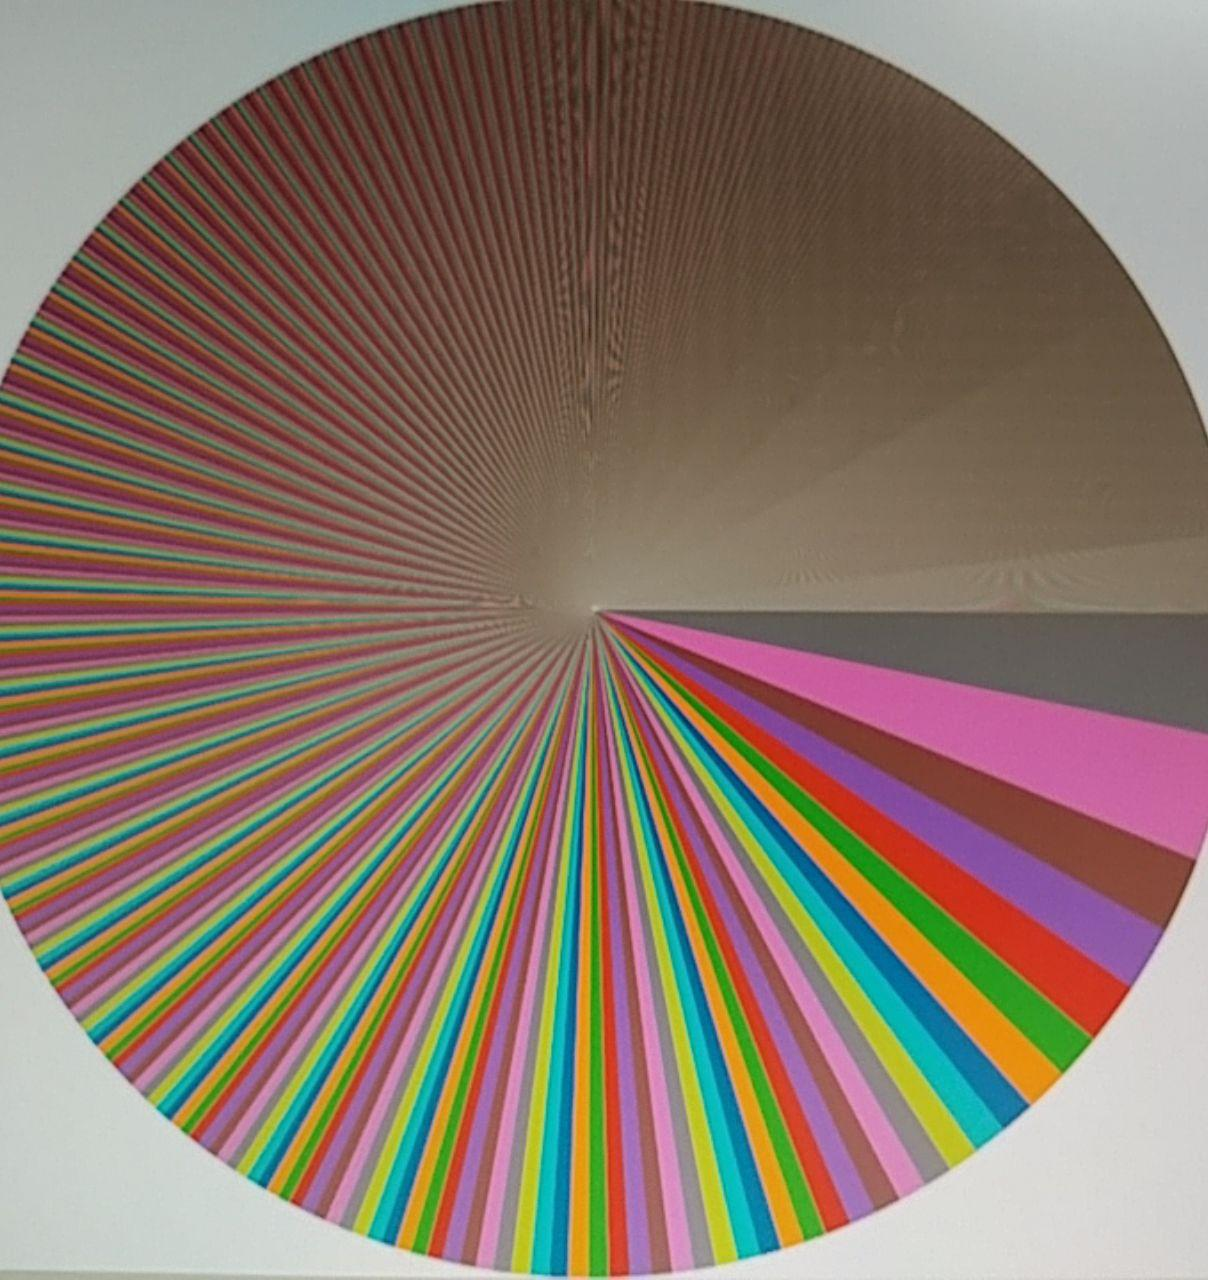

اما بر خلاف انتظار، این سرت کردن تاثیر زیادی نداشت.

### کد این بخش:

In [ ]:
def creatingAdsWithWordsDF(oldAdTitle, trainDisplayId):
    adTitle=getAdTitleDataWithCountColumn(oldAdTitle, -1)
    numberOfWords = 5
    columnsList = []
    for col in trainDisplayId.columns:
        columnsList.append(col)
    for i in range(numberOfWords):
        columnsList.append('wordId' + str(i))
        
    adTitle = adTitle.sort_values(by = ['adId']).drop(columns=['count']).to_numpy()
    trainForAdId = trainDisplayId.sort_values(by = ['adId']).to_numpy()

    (trainn, trainm) = trainForAdId.shape
    (adn, adm) = adTitle.shape

    (resn, resm) = (trainn, trainm + numberOfWords)

    result = np.zeros((resn, resm), dtype = np.int64)
    
    
    curr = 0
    for i in range(trainn):
        while curr < adn and adTitle[curr][0] < trainForAdId[i][1]: #1 is adId col
            curr += 1

        if curr < adn and trainForAdId[i][1] == adTitle[curr][0]:
            cnt = 0
            for j in range(0, trainm):
                result[i][cnt] = trainForAdId[i][j]
                cnt += 1
            for j in range(numberOfWords):
                if adTitle[curr + j][0] == adTitle[curr][0]:
                    result[i][cnt] = adTitle[curr + j][1]
                else:
                    result[i][cnt] = 0 #Salam bar tof!
                cnt += 1
        else:
            cnt = 0
            for j in range(0, trainm):
                result[i][cnt] = trainForAdId[i][j]
                cnt += 1
            for j in range(numberOfWords):
                result[i][cnt] = 0 #Salam bar tof!
                cnt += 1

    trainMerged = pd.DataFrame(data = result, columns = columnsList)
    trainMerged = trainMerged.sort_values(by = ['displayId'])
    return trainMerged

adTitle = pd.read_csv('ad_title.csv')
train=creatingAdsWithWordsDF(adTitle, trainDisplayId)
train.head()
#train = trainMerged.copy(deep = True)
#train.head()

## استفاده از الگوریتم های مختلف یادگیری

از الگوریتم های مختلف یادگیری استفاده کردیم اما بهترین آن ها الگوریتم

DecisionTreeClassifier

بود که به ما احتمال این که فرد روی هر آگهی کلیک کند را نیز می داد

### کد این بخش:

In [5]:
def learn(X_train, y_train, X_test, importantColumns, randomState):
    from sklearn.tree import DecisionTreeClassifier
    
    treeModel = DecisionTreeClassifier(random_state=randomState, max_depth=15)
    
    X_train = X_train[importantColumns]
    X_test = X_test[importantColumns]
    
    
    treeModel.fit(X_train, y_train)
    
    predictions = treeModel.predict_proba(X_test)
    return predictions